# Frequency Bin Mapping
## SDDR Riometer

The following notebook deals with mapping input RF frequency signals generated in the lab to the proper frequency bin in the SDDR. The test parameters are:

- Cadence: 4 seconds/ bin.
- Frequency Range: 50 MHz - 12.24 kHz.
- Bandwidth: 12.24 kHz.
- Number of Bins (FFT size): 4084.

*** The number of bins is 4084 coming out of the FFT, meaning that the data has to be interpreted in 4084 bins.***

We can measure the difference in number of bins:

$$ Offset = Expected \ Frequency \ Bin - Measured \ Frequency \ Bin $$

We can then use this offset to construct a new frequency space that shifts the $ Measured \ Frequency \ Bin $ by this $ Offset $.

___

### Loading Data

First we load the data of the day of the test.

In [8]:
sys.path.insert(1, '/home/phelz/lab-tests/SDDR Tests/')

import functions as fns
from datetime import datetime, timedelta

In [2]:
import os
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

year = "2021"
month = "08"; month_string = 'Jul'
day = "27"
site = "calg"
device = "iris-00"
sddr = "sddr4a"

save_file_root = "/home/phelz/lab-tests/Data/Bin Mapping/Aug 27/"

In [3]:
save_file = "%s%s/%s/%s/%s/%s%s%s_%s_%s_%s_standard.npz" % (save_file_root,year,month,day,sddr,year,month,day,site,device,sddr)
print(save_file)

/home/phelz/lab-tests/Data/Bin Mapping/Aug 27/2021/08/27/sddr4a/20210827_calg_iris-00_sddr4a_standard.npz


In [4]:
data_struct = np.load(save_file, allow_pickle=True)

data_array = np.array(data_struct['data'])
data_array = np.fliplr(np.flip(data_array).T)#[:,0:3600] #spin data array so bottom left corner is time = 0 and freq = 0

time_array = data_struct['time']#[0:3600]

meta_data_array = data_struct['meta_data']

fpga_version = data_struct['fpga_version']

data_struct = [] # free memory
gc.collect()

22

### Bin Mapping

The results below show the need for an exact mapping method. In the plot, one can see that the difference in number of bins between the input RF frequency and the corresponding riometer frequency is not linear but rather a step function (with some bins not following any trend at all).

In [6]:
def check_nearby_bins(i, data_array, start_indx, end_indx):
    ''' A function that goes through a collection of frequency bins (12 in this case) before and after the current bin, checking which is the one with the highest power. '''

    # Empty arrays for storing the average of each bin and the corresponding bin index
    avgs = []
    bins = [] # bin indices

    # Number of bins to look in both before and after
    offset = 12

    for j in range( i - offset, i + offset):

        # Store the power of each bin as well as the average
        pwr = data_array[j][start_indx:end_indx]
        avg = np.mean(pwr)

        # Store that average and the corresponding bin index
        avgs.append(avg)
        bins.append(j)

    # Find the maximum of the averages
    max_avg = np.max(avgs)
    indx = np.where(avgs == max_avg)
    
    # Get the number of the bin with the maximum average
    bins = np.asarray(bins) # turn into a numpy array instead of a python list to avoid problems
    bin_number = bins[indx][0]

    return max_avg, bin_number

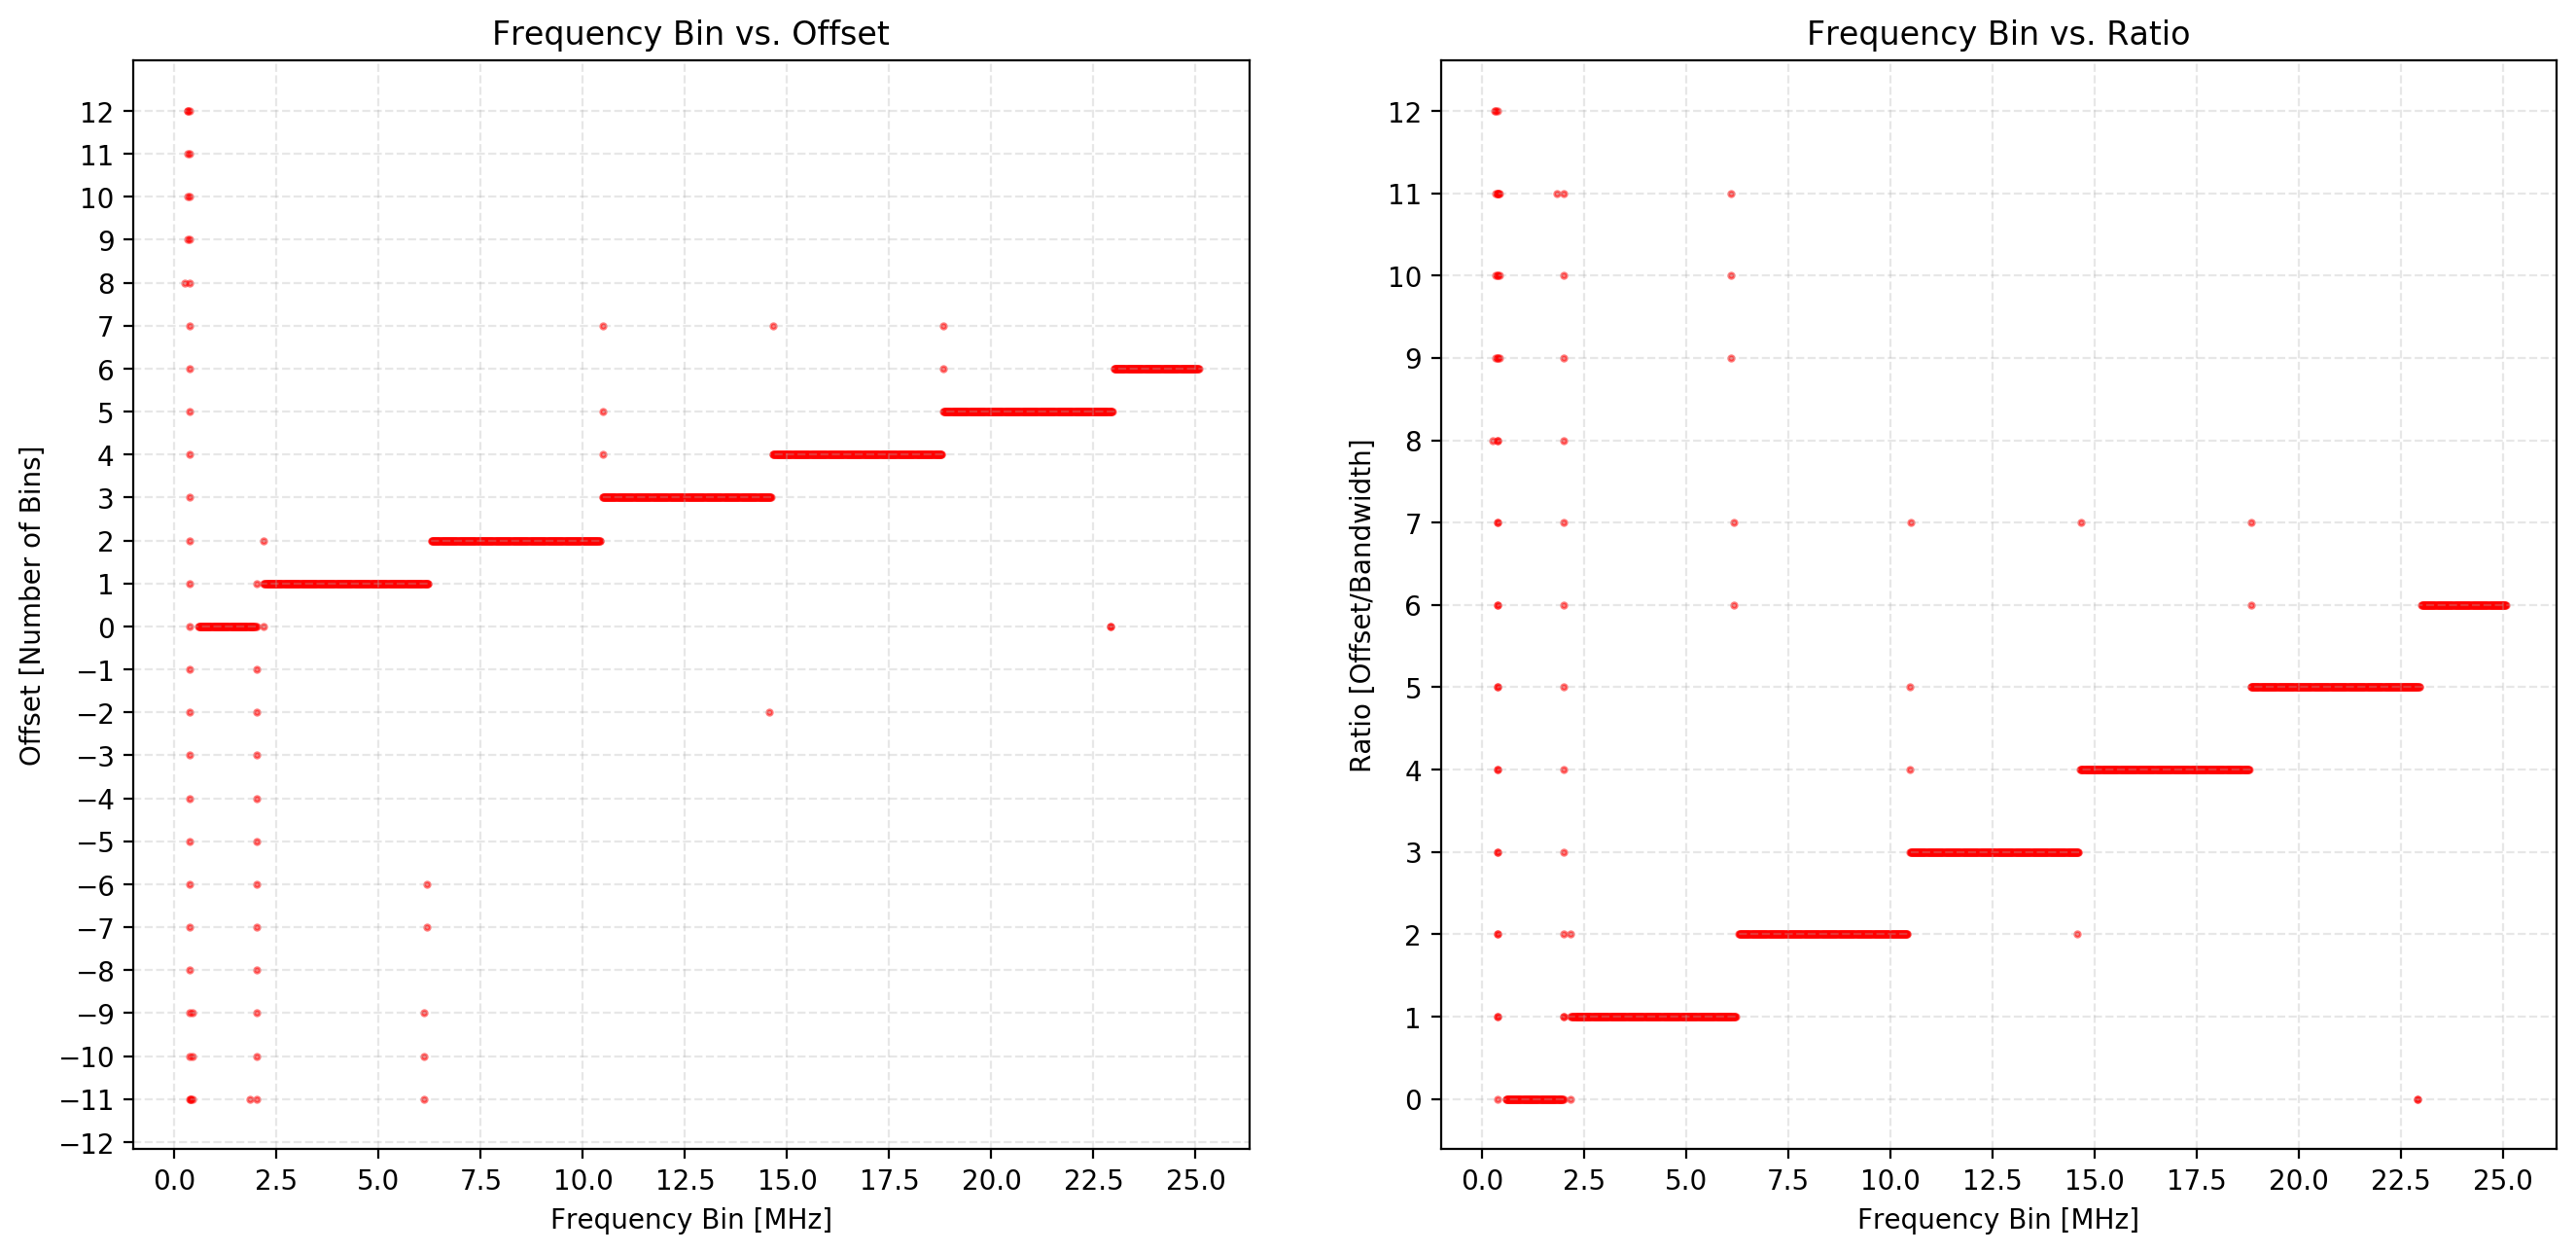

In [23]:
# Original Frequency Space
freq_space = np.linspace(50,0,num=4084, endpoint=False)
BW = -(freq_space[-1] - freq_space[-2]) # Bandwidth

# A copy of the original frequency space that will be the the new frequency space
new_freq_space = freq_space.copy()

# Timing
# First reset the time_array by stripping off microseconds
# This helps identify specific times during the data collection period
time_array = np.vectorize(fns.reset)(time_array) # -- this function is defined elsewhere

# Start at 25 MHz
start_time = datetime(int(year), int(month), int(day), 16, 28) # start time of test
dt = timedelta(seconds=4) # data collection interval
end_time = start_time + dt # end time of first bin collection period
# ----------------------------------------------------------------------------------------------------------------------------------

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex= False, sharey = False, dpi = 200)
fig.tight_layout(pad=4.0)
fig.set_facecolor('white')
plt.setp(axes, xlabel = "Frequency Bin [MHz]")


# Start from 25 MHz for now... until we have full test
size = data_array.shape[0] # size of frequency space
for i in range(size//2, size+1, 1):

    # Get start and end time of active bin in the test
    start_indx, end_indx = fns.get_time_indices(start_time, end_time, time_array) # -- this function is defined elsewhere

    # Get the maximum average and the correct bin number
    max_avg, bin_number = check_nearby_bins(i, data_array, start_indx, end_indx)

    actual_freq = freq_space[i] # this is the frequency as supplied by the signal generator
    measured_freq = freq_space[bin_number] # this is the frequency as measured by the riometer

    offset = i - bin_number # offset in number of bins
    freq_diff = abs(actual_freq - measured_freq) # offset in freq
    ratio = freq_diff/BW # ratio relative to bandwidth

    # ----------------------------------------------------------------------------------------------------------------------------------

    # # Some print statements
    # string_bins = "Power = %.2f, Actual Bin = %d, Should be = %d, Difference = %d bins" % (max_avg, i, bin_number ,i - bin_number )
    # print(string_bins)
    # string_freq = "Actual Freq = %.4f, Measured Freq = %.4f, Diff = %.4f kHz, Current BW = %.4f kHz, Ratio = %.4f" % (actual_freq, measured_freq, freq_diff*1000, BW*1000, ratio )
    # print(string_freq)
    # print('\n')

    #----------------------------------------------------------------------------------------------------------------------------------

    # Advance the start and end times by the data collection period to go to the next bin
    start_time += dt
    end_time += dt

    # In the new_freq_space, adjust the frequency to match the offset
    if offset >= 0: new_freq_space[i] -= offset*BW
    elif offset < 0: new_freq_space[i] += offset*BW

    # Below this point the numbers calculated get either too large or too small and it yields errors
    # Can work around it, and don't need these bins
    if actual_freq < 0.15: break

    # Plotting
    axes[0].scatter(measured_freq, i - bin_number, color = 'r', s = 4, alpha = 0.5)
    axes[1].scatter(measured_freq, ratio, color = 'r', s = 4, alpha = 0.5)


axes[1].set_ylabel('Ratio [Offset/Bandwidth]')
axes[1].set_title('Frequency Bin vs. Ratio')    
axes[1].set_yticks(np.arange(0, 13, 1))    
axes[1].set_xticks(np.arange(0, 25+2.5, 2.5))    
axes[1].grid(True, alpha = 0.3, linestyle = '--')   

axes[0].set_ylabel('Offset [Number of Bins]')    
axes[0].set_title('Frequency Bin vs. Offset')    
axes[0].set_yticks(np.arange(-12, 13, 1))    
axes[0].set_xticks(np.arange(0, 25+2.5, 2.5))    
axes[0].grid(True, alpha = 0.3, linestyle = '--') 

plt.savefig('Bin Mapping - Step Function.png')
plt.show()

### New Frequency Space

For the most part, the above algorithm will construct a new frequency space that is exactly precise according to what the riometer measures. Except for the last few bins. In those bins, the offsets get extremely large. Those are the bins below $ < 0.15 ~MHz $, which we can replace with what the original frequency space would have had.

Then we save the output in a `.txt` file.

In [24]:
# Measure the amount of bins lost
bin_diff = 4084 - new_freq_space.shape[0]

# Get the last bin from the new_freq_space and construct another array with size = bin_diff
last_bin = new_freq_space[-1]
last_bit = np.linspace(last_bin, 0, num=bin_diff, endpoint = False)

# Append those two arrays
new_freq_space = np.append(new_freq_space, last_bit)

# Save the file
np.savetxt('freq_space_exp.out' ,new_freq_space) # apparently there's a thing called .out files
np.savetxt('freq_space_exp.txt' ,new_freq_space)

# print(bin_diff, last_bin, new_freq_space.shape)
